# waves

> Learn something about waves

In [ ]:
#|default_exp waves

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wf, scipy.stats as st
from fastcore.all import *
from copy import copy

In [ ]:
class actionWrap:
    def __init__(self, f, act): store_attr()
    def __set_name__(self, cls, name): self.act(self, cls, name)
    def __call__(self): pass
    def __str__(self): pass
    def __repr__(self): pass


In [ ]:
from functools import update_wrapper, WRAPPER_ASSIGNMENTS
def implements(np_func):
        "Register an __array_function__ implementation"
        def act(desc, cls, name): cls.HANDLED_FUNCTIONS[np_func]=desc
        def _f(func): 
                return update_wrapper(actionWrap(func, act), func,WRAPPER_ASSIGNMENTS+('__call__','__repr__','__str__'))
        return _f

In [ ]:
class Wave:
    HANDLED_FUNCTIONS = {}
    # sum = implements(np.sum)(sum)
    @implements(np.sum)
    def sum(self, other):
        '''docs'''
        print('hello')
        return self + other
    
    def min(self): pass

In [ ]:
Wave().sum()

In [ ]:
class A:
    def __init__(self, number=1):
        self.n=number
    
    def printer(self):
        print(self.n)
    
    printer = decorator('a')(printer)
    

inited decorator
decorator ate function and returned descriptor
<__main__.descriptorF object>
<class '__main__.A'> printer


In [ ]:
A.printer

<__main__.descriptorF>

In [ ]:
def implements(np_function):
        "Register an __array_function__ implementation"
        def decorator(func):
            NumpyHelper.HANDLED_FUNCTIONS[np_function] = func
            return func
        return decorator

In [ ]:
class NumpyHelper(np.lib.mixins.NDArrayOperatorsMixin):
    HANDLED_FUNCTIONS={}
    
    def __array_function__(self, func, types, args, kwargs):
        if func not in self.HANDLED_FUNCTIONS:
            return NotImplemented
        # Note: this allows subclasses that don't override
        # __array_function__ to handle DiagonalArray objects.
        if not all(issubclass(t, self.__class__) for t in types):
            return NotImplemented
        return self.HANDLED_FUNCTIONS[func](*args, **kwargs)

In [ ]:
# TODO
# 1. class aware decorator
# 2. numpy helper that has __array_function__ and __array_ufunc__ that do their thing in a way that if class 
# has HANDLED_FUNCTION it should call it on the object, otherwise some default behavior, whatever
# 3. Implement function class, you can add functions, subtract, multiply negate, show them, concatenate their domains(which is like addition)
# Also special methods like horizontal shift and scale(where you don't add scalar to y, but to x) 
# 4. Create waves that are just aliases for functions of sine, Pulse is a product of gaussian function and wave
# 5. Create sound class, that has discretizatoin rate and time, classes that inherit from it can be converted to wav
# 6. so then we can inherit from sound and from wave and build some sequences of pulses of different sizes and amplitudes

In [ ]:
class Function(np.lib.mixins.NDArrayOperatorsMixin):
    _custom_ops = ['']
    def __init__(self, func, x_min=-5, x_max=5, num=1000):
        self.x = np.linspace(x_min, x_max, num)
        self.y = func(self.x)
        
    def __array__(self, dtype=None, **kwargs): return np.stack([self.x,self.y],dtype)
    
    def __array_ufunc__(self, ufunc, method, *inputs, **kwargs):
        if method == '__call__':
            inputs = tuple(i.y if isinstance(i,Function) else i for i in inputs)
            res = self.__class__(N, ufunc(*inputs, **kwargs))
            y = ufunc(*inputs, **kwargs)
            return self.__class__(N, ufunc(*inputs, **kwargs))
        else:
            return NotImplemented
         
    def show(self, ax=None):
        ax = ifnone(ax, plt.subplots()[1])
        ax.plot(self)

In [ ]:
np.add(Function(lambda x: x*x),Function(lambda x: 2*x))

__call__ <ufunc 'add'>


AttributeError: 'Function' object has no attribute 'data'

In [ ]:
#|export

class Wave(np.array):
    def __init__(self, data, rate=44_100):
        super().__init__(data, np.float32)

    def show(self, n_period=5, ax=None):
        ax = ifnone(ax, plt.subplots()[1])
        d = self.data if n_period is None else self.data[:n_period*self.rate//self.freq]
        ax.plot(d)
    def save(self,fname): wf.write(fname, self.rate, self)
    


class Wave:
    def __init__(self, freq, seconds=1, rate=44_100, volume=1):
        '''human can hear frequencies from 20 Hz to 20.000 Hz'''
        store_attr()
        self.t = np.linspace(0.,seconds, int(np.round(rate*seconds)), dtype=np.float32)
        self.data = volume*np.sin(np.pi*2*freq*self.t)
    
    def save(self,fname): wf.write(fname, self.rate, self.data)
    
    def show(self, n_period=5, ax=None):
        ax = ifnone(ax, plt.subplots()[1])
        d = self.data if n_period is None else self.data[:n_period*self.rate//self.freq]
        ax.plot(d)
    
    def __neg__(self): 
        res = copy(self)
        res.data = -self.data
        return res
    
    def __add__(self, other):
        res = copy(self)
        if isinstance(other, Wave):
            assert self.rate == other.rate
            res.data = self.data + other.data
        else: res.data += other
        return res
    
    def __sub__(self, other): return self + (-other)


class Pulse(Wave):
    def __init__(self, freq, seconds=1, rate=44_100, max_volume=1, ratio=2):
        super().__init__(freq, seconds, rate)
        volume = st.norm.pdf(self.t, self.t.mean(), self.t.std()/ratio).astype(np.float32)
        self.data = volume/volume.max()*max_volume*np.sin(np.pi*2*freq*self.t)

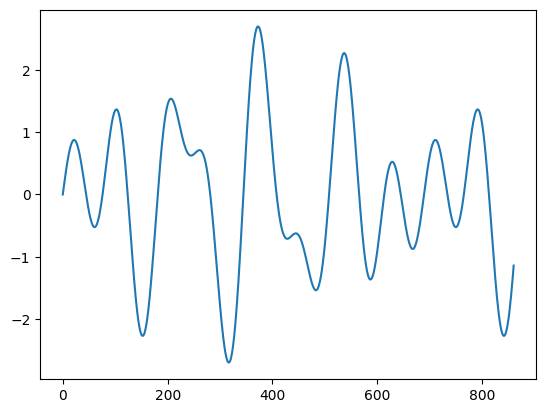

In [ ]:
freq = 256
t = 10
wav = Wave(freq, t)+ Wave(2*freq,t) - Wave(freq*5/4,t)
wav.show()
wav.save('test.wav')

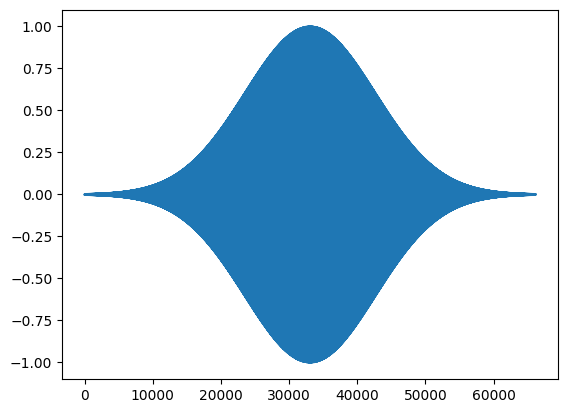

In [ ]:
p = Pulse(256*5, 1.5)
p.show(None)
p.save('test.wav')

In [ ]:
#|export
class Sound:
    def __init__(self): pass
    
        